In [2]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# sorting data from a file
datapath = "output/eye_data.csv"

# convert to dataframe
import pandas as pd
df = pd.read_csv(datapath)

# open the output fodler and read all of the files

# create a list of all the image files
# and their labels
image_numbers = df['frame_idx'].tolist()
# load image
print("image_numbers", image_numbers[-1])

images = []
coords = []
coordsv = []
for idx, row in df.iterrows():
    if idx % 100 == 0:
        print(f"Processing {idx}/{len(df)}")
    frame_num = int(row['frame_idx'])
    image_path = f"output/{frame_num}.png"
    image = cv2.imread(image_path)
    if image is None:
        continue
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h = image.shape[0]
    scale = 128 / h
    # resize the image to 128x128
    image = cv2.resize(image, (128, 128))/255
    images.append(image)
    coords.append((row['ellipse_x']/ h
                #    , row['ellipse_y']/h
                   ))
    coordsv.append(row['ellipse_y']/ h)

    # coords.append((row['ellipse_x'] * scale, row['ellipse_y'] * scale, row['ellipse_w'] * scale/2, row['ellipse_h'] * scale/2))



image_numbers 10389
Processing 0/10389
Processing 100/10389
Processing 200/10389
Processing 300/10389
Processing 400/10389
Processing 500/10389
Processing 600/10389
Processing 700/10389
Processing 800/10389
Processing 900/10389
Processing 1000/10389
Processing 1100/10389
Processing 1200/10389
Processing 1300/10389
Processing 1400/10389
Processing 1500/10389
Processing 1600/10389
Processing 1700/10389
Processing 1800/10389
Processing 1900/10389
Processing 2000/10389
Processing 2100/10389
Processing 2200/10389
Processing 2300/10389
Processing 2400/10389
Processing 2500/10389
Processing 2600/10389
Processing 2700/10389
Processing 2800/10389
Processing 2900/10389
Processing 3000/10389
Processing 3100/10389
Processing 3200/10389
Processing 3300/10389
Processing 3400/10389
Processing 3500/10389
Processing 3600/10389
Processing 3700/10389
Processing 3800/10389
Processing 3900/10389
Processing 4000/10389
Processing 4100/10389
Processing 4200/10389
Processing 4300/10389
Processing 4400/10389
Pr

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr_x, y_te_x = train_test_split(
    images, coords, test_size=0.2, random_state=42
)
X_tr, X_te, y_tr_y, y_te_y = train_test_split(
    images, coordsv, test_size=0.2, random_state=42
)

def photometric_augment(image, label):
    # image: [128,128,1], float32 ∈ [0,1]
    img = image
    img = tf.cast(image, tf.float32)

    img = tf.image.random_brightness(img, max_delta=0.4)
    # Add Gaussian noise σ≈0.02
    noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.02)
    img = tf.clip_by_value(img + noise, 0.0, 1.0)
    return img, label
def make_dataset(X, y, batch_size=32):
    # 1) build the original dataset
    ds_orig = tf.data.Dataset.from_tensor_slices((X, y))
    
    # 2) immediately cast both image and label to float32
    ds_orig = ds_orig.map(
        lambda img, lbl: (tf.cast(img, tf.float32), tf.cast(lbl, tf.float32)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # 3) build the augmented copy (now also float32)
    ds_aug = ds_orig.map(
        photometric_augment, 
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # 4) concatenate, shuffle, batch, prefetch
    return (
        ds_orig
        .concatenate(ds_aug)
        .shuffle(buffer_size=len(X)*2)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
train_ds_x = make_dataset(X_tr, y_tr_x)
val_ds_x   = tf.data.Dataset.from_tensor_slices((X_te, y_te_x))\
                 .batch(32).prefetch(tf.data.AUTOTUNE)

train_ds_y = make_dataset(X_tr, y_tr_y)
val_ds_y   = tf.data.Dataset.from_tensor_slices((X_te, y_te_y))\
                 .batch(32).prefetch(tf.data.AUTOTUNE)
def build_model(input_shape=(128,128,1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder: 3 × (Conv → ReLU → MaxPool)
    x = layers.Conv2D(32, 7, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)   # 64×64×32

    x = layers.Conv2D(64, 5, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)   # 32×32×64

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)   # 16×16×128

    # Flatten and dense head
    x = layers.Flatten()(x)         # 16*16*128 = 32768
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='linear')(x)  # (x, y)

    model = models.Model(inputs, outputs, name="CoordNet")
    return model

model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()




Model: "CoordNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_45 (Conv2D)          (None, 128, 128, 32)      1600      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 64, 64, 64)        51264     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 128)       738

In [5]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model_x = build_model()
model_x.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_x.fit(
    train_ds_x,
    validation_data=val_ds_x,
    epochs=50,
    callbacks=[early_stop]
)
loss_x, mae_x = model_x.evaluate(val_ds_x)
print(f"X-model MAE (norm): {mae_x:.4f}")


Epoch 1/50
520/520 [==============================] - 16s 20ms/step - loss: 0.2502 - mae: 0.1046 - val_loss: 0.0011 - val_mae: 0.0277
Epoch 2/50
520/520 [==============================] - 12s 16ms/step - loss: 0.0074 - mae: 0.0685 - val_loss: 0.0027 - val_mae: 0.0493
Epoch 3/50
520/520 [==============================] - 12s 17ms/step - loss: 0.0064 - mae: 0.0636 - val_loss: 3.5067e-04 - val_mae: 0.0132
Epoch 4/50
520/520 [==============================] - 13s 18ms/step - loss: 0.0054 - mae: 0.0581 - val_loss: 4.2218e-04 - val_mae: 0.0169
Epoch 5/50
520/520 [==============================] - 13s 18ms/step - loss: 0.0044 - mae: 0.0527 - val_loss: 2.3803e-04 - val_mae: 0.0114
Epoch 6/50
520/520 [==============================] - 13s 20ms/step - loss: 0.0036 - mae: 0.0473 - val_loss: 4.0078e-04 - val_mae: 0.0162
Epoch 7/50
520/520 [==============================] - 18s 23ms/step - loss: 0.0026 - mae: 0.0406 - val_loss: 4.2103e-04 - val_mae: 0.0178
Epoch 8/50
520/520 [======================

In [6]:
model_y = build_model()
model_y.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_y.fit(
    train_ds_y,
    validation_data=val_ds_y,
    epochs=50,
    callbacks=[early_stop]
)
loss_y, mae_y = model_y.evaluate(val_ds_y)
print(f"Y-model MAE (norm): {mae_y:.4f}")

Epoch 1/50
520/520 [==============================] - 24s 29ms/step - loss: 0.0509 - mae: 0.0610 - val_loss: 6.5045e-04 - val_mae: 0.0171
Epoch 2/50
520/520 [==============================] - 14s 22ms/step - loss: 0.0025 - mae: 0.0394 - val_loss: 0.0014 - val_mae: 0.0336
Epoch 3/50
520/520 [==============================] - 10s 16ms/step - loss: 0.0022 - mae: 0.0371 - val_loss: 6.2908e-04 - val_mae: 0.0198
Epoch 4/50
520/520 [==============================] - 10s 16ms/step - loss: 0.0019 - mae: 0.0350 - val_loss: 7.5727e-04 - val_mae: 0.0223
Epoch 5/50
520/520 [==============================] - 10s 16ms/step - loss: 0.0016 - mae: 0.0320 - val_loss: 2.3431e-04 - val_mae: 0.0089
Epoch 6/50
520/520 [==============================] - 11s 18ms/step - loss: 0.0014 - mae: 0.0290 - val_loss: 2.8113e-04 - val_mae: 0.0123
Epoch 7/50
520/520 [==============================] - 15s 24ms/step - loss: 0.0011 - mae: 0.0256 - val_loss: 1.9902e-04 - val_mae: 0.0098
Epoch 8/50
520/520 [==================

1/1 [==============================] - 0s 36ms/step


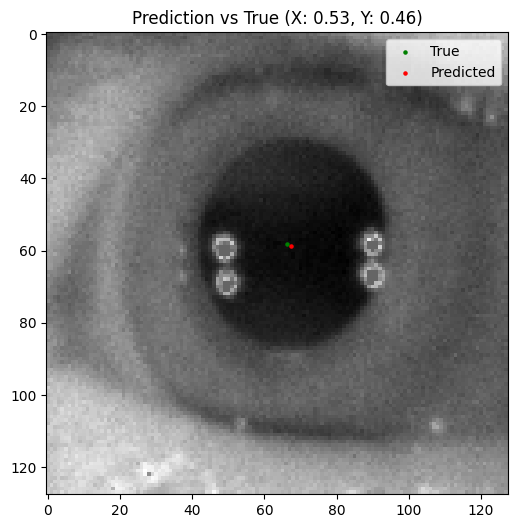

1/1 [==============================] - 0s 32ms/step


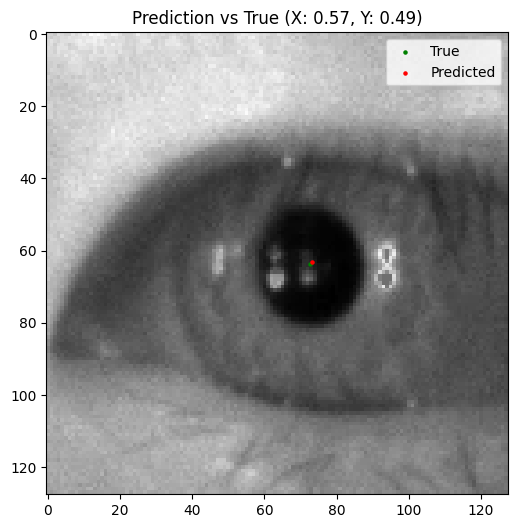

1/1 [==============================] - 0s 55ms/step


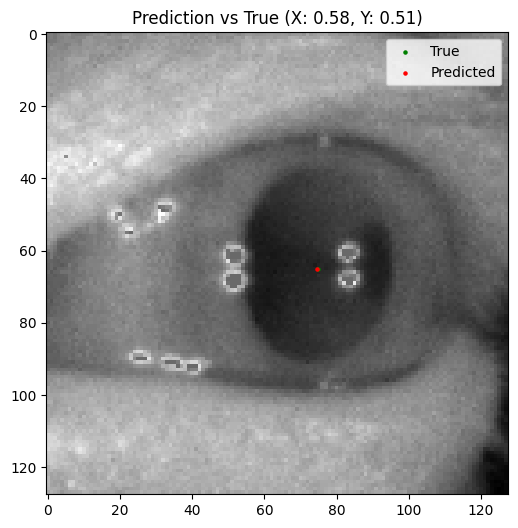

1/1 [==============================] - 0s 33ms/step


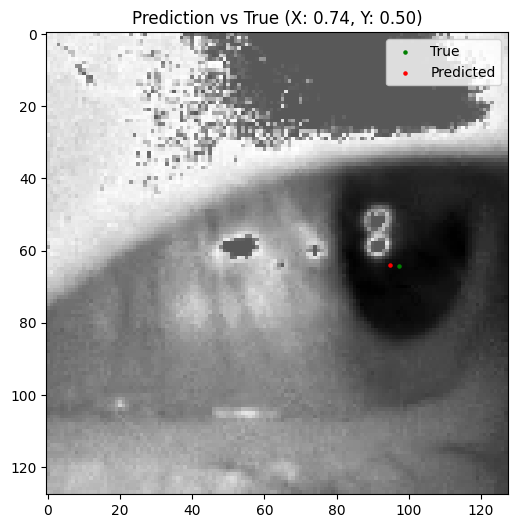

1/1 [==============================] - 0s 34ms/step


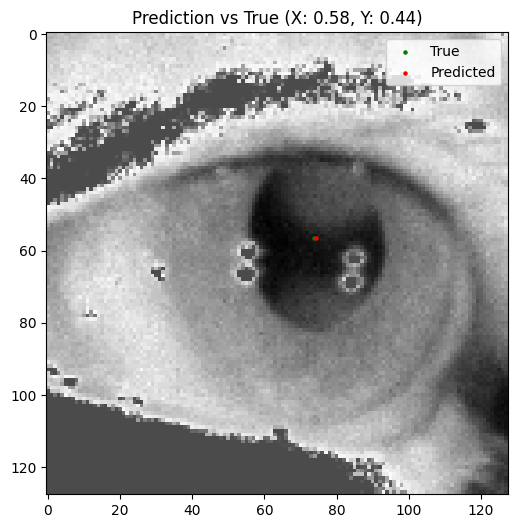

1/1 [==============================] - 0s 34ms/step


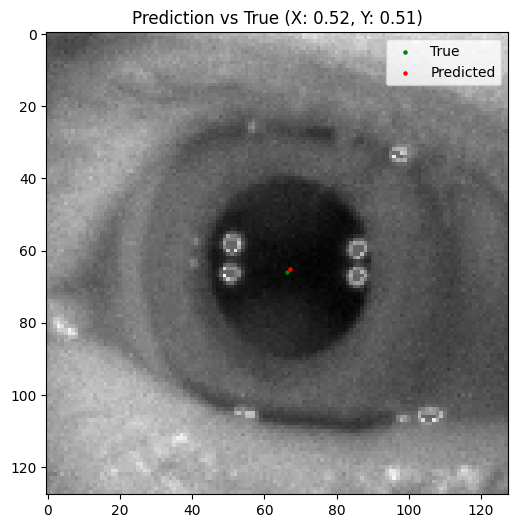

1/1 [==============================] - 0s 37ms/step


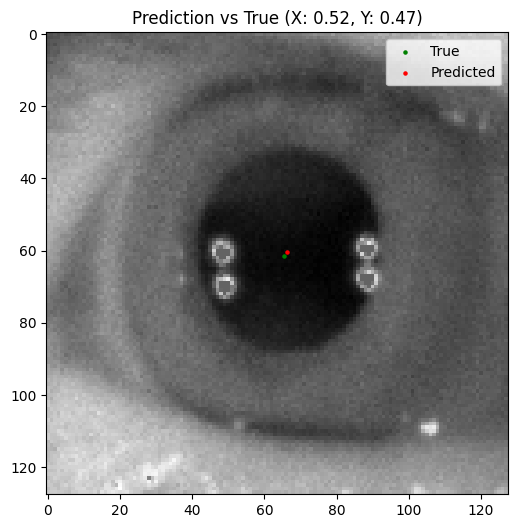

1/1 [==============================] - 0s 38ms/step


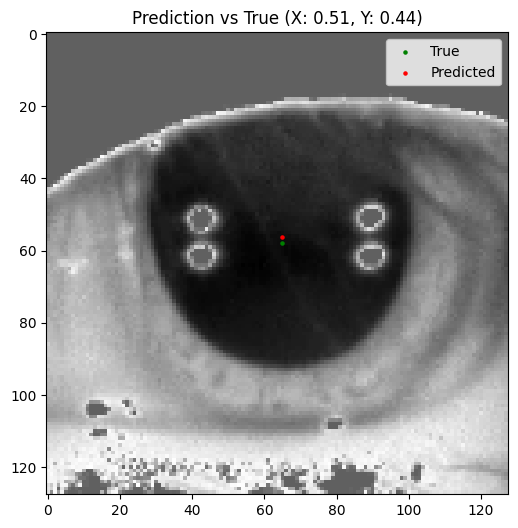

1/1 [==============================] - 0s 37ms/step


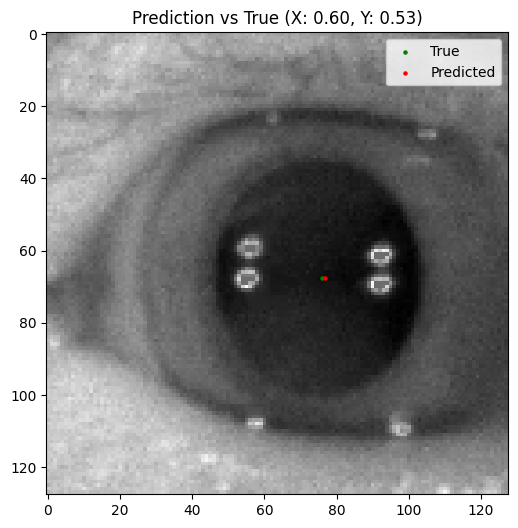

1/1 [==============================] - 0s 37ms/step


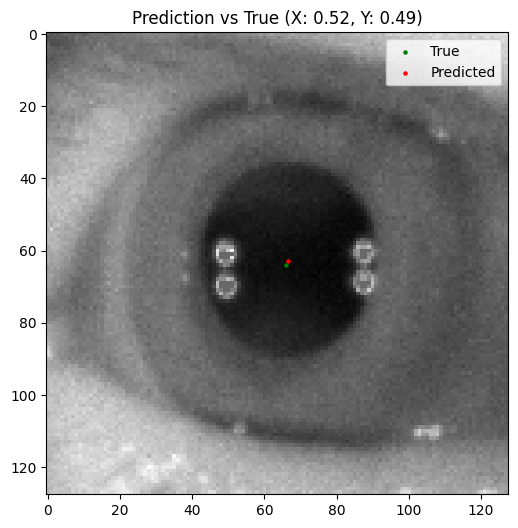

In [59]:
for i in range(10):
    idx = np.random.randint(len(X_te))
    img = X_te[idx]
    true_x = y_te_x[idx]
    true_y = y_te_y[idx]
    
    pred_x = model_x.predict(np.expand_dims(img, axis=0))[0][0]
    pred_y = model_y.predict(np.expand_dims(img, axis=0))[0][0]

    plt.figure(figsize=(6, 6))
    plt.imshow(img.squeeze(), cmap='gray')
    plt.scatter([true_x * 128], [true_y * 128], color='green', label='True', s=5)
    plt.scatter([pred_x * 128], [pred_y * 128], color='red', label='Predicted', s=5)
    plt.title(f"Prediction vs True (X: {pred_x:.2f}, Y: {pred_y:.2f})")
    plt.legend()
    plt.show()

In [60]:

model_x.save("eye_tracking_model_x.keras")
model_y.save("eye_tracking_model_y.keras")
# convert to tflite
converter_x = tf.lite.TFLiteConverter.from_keras_model(model_x)
converter_x.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_x = converter_x.convert()
with open("eye_tracking_model_x.tflite", "wb") as f:
    f.write(tflite_model_x)
converter_y = tf.lite.TFLiteConverter.from_keras_model(model_y)
converter_y.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_y = converter_y.convert()
with open("eye_tracking_model_y.tflite", "wb") as f:
    f.write(tflite_model_y)


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmpy5nl5_j4\assets


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmpy5nl5_j4\assets


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmp3yz42yvt\assets


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmp3yz42yvt\assets
